In [17]:
# Author: Aditya Ranganath
# Subject: Exploring optical flow and predicting frames based on Taylor expansion 

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image

In [81]:
cap = cv2.VideoCapture('./data/circle_noise1.avi')

# We know the frame rate for the video is 10 fps
deltat = 1/10

# Compute the flow of two images and the compute then flow of flow with two flows
# For that, extract one image from flow
# then extract the next images in the loop

_, prev= cap.read()

Iot = prev

hsv_mask = np.zeros_like(prev)

prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

flowl = []
for i in range(2):    
    # we need only only flow sample and one flow of flow sample
    _, next = cap.read()

    hsv_mask = np.zeros_like(next)

    # Calculate the flow for a Black and white render
    next = cv2.cvtColor(next, cv2.COLOR_BGR2GRAY)

    #Compute the flow for these two images
    flow = cv2.calcOpticalFlowFarneback(prev, next, 2, levels=20, winsize=1, iterations=5, poly_n=1,poly_sigma=1.2, flags=0, pyr_scale=0.5)

    # Compute magnite and angle of 2D vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Set value as per the normalized magnitude of optical flow
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Set image hue value according to the angle of optical flow
    hsv_mask[..., 0] = ang * 180 / np.pi / 2

    # Convert to rgb
    rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

    # Append to flow list
    flowl.append(rgb_representation)

    prev = next

    hsv_mask = np.zeros_like(prev)

# Now compute the initial flow of flow
fflow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(flowl[0], cv2.COLOR_BGR2GRAY), cv2.cvtColor(flowl[1], cv2.COLOR_BGR2GRAY), 2, levels=20, winsize=60, iterations=5, poly_n=1,poly_sigma=1.2, flags=0, pyr_scale=0.1)

# Compute magnite and angle of 2D vector
mag, ang = cv2.cartToPolar(fflow[..., 0], fflow[..., 1])

#Set the mask to zero again
hsv_mask = np.zeros_like(flowl[0])

# Set value as per the normalized magnitude of optical flow
hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

# Now that we have the flow and flow of flows, lets calculate the Image!
# The formulation for the image is given by
# I(t + \Delta t) = I(t) + \Delta t * flow[0] + \frac{1}{2} \Delta t^2 fflow[0]

# Convert to rgb
fflow = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

# Computing the next frame
Idt = lambda dt: Iot + flowl[1]*deltat + 0.5*fflow*deltat**2

# Save to a list and return
Idtl = []

# Release and reset
cap.release()

# Read the file again to reset
cap = cv2.VideoCapture('./data/circle_noise1.avi')

#The new sampling rate
newdeltat = 1/20

i = 0

for j in range(200):
    try:
        _, Iot = cap.read()
        Idtl.append(Iot)
        for i in range(2):
            weight = np.uint8(0.5)
            Inext = Idt((i+1)*newdeltat)
            # weighted sum between frames
            mid_frame = cv2.addWeighted(np.uint8(Iot),np.uint8(weight),np.uint8(Inext),1-weight,0)
            Idtl.append(mid_frame)
            Idtl.append(np.uint8(Inext))
            i=i+1
            Iot= mid_frame
    except:
        break

In [82]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
FPS = 40
width, height = 64,64
import numpy as np
video = cv2.VideoWriter('./data/circle_noise_restored.avi', fourcc, float(FPS), (width, height))

for frame in Idtl:
    try:
        video.write(frame)
    except:
        set_trace()
video.release()

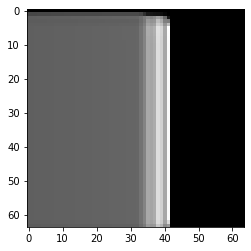

In [80]:
# cv2.imshow('flowoflfow',fflow)
import matplotlib.pyplot as plt
plt.imshow(fflow)
# plt.imshow(flowl[1])